In [ ]:
# %pip install -q "monai[nibabel]"

In [1]:
import glob
import torch

import torch.utils.data as data
import numpy as np
import nibabel as nb
# from commons import MRIDataset
from monai.utils import first

In [2]:
class MRIDataset(data.Dataset):
    def __init__(self, X_files, y_files, transforms=None):
        self.X_files = X_files
        self.y_files = y_files
        self.transforms = transforms
    
        img_array = list()
        label_array = list()
        for vol_f, label_f in zip(self.X_files, self.y_files):
            img, label = nb.load(vol_f), nb.load(label_f)
            img_data = np.array(img.get_fdata())
            label_data = np.array(label.get_fdata())
            
            # Transforming to Axial Manually.
            img_data = np.rollaxis(img_data, 2, 0)
            label_data = np.rollaxis(label_data, 2, 0)
            
            img_array.extend(img_data)
            label_array.extend(label_data)
            img.uncache()
            label.uncache()
            
        X = np.stack(img_array, axis=0) if len(img_array) > 1 else img_array[0]
        y = np.stack(label_array, axis=0) if len(label_array) > 1 else label_array[0]
        self.X = X if len(X.shape) == 4 else X[:, np.newaxis, :, :]
        self.y = y
        print(self.X.shape, self.y.shape)
        
    def __getitem__(self, index):
        img = torch.from_numpy(self.X[index])
        label = torch.from_numpy(self.y[index])
        return img, label

    def __len__(self):
        return len(self.y)


In [3]:
ukb_volumes = sorted(glob.glob(f'temp/UKB/processed_resized/volume_cropped/**.nii.gz'))
ukb_labels = sorted(glob.glob(f'temp/UKB/processed_resized/label_cropped/**.nii.gz'))

ds = MRIDataset(ukb_volumes, ukb_labels)
loader = torch.utils.data.DataLoader(ds, batch_size=3, num_workers=4)

im, seg = first(loader)
print(im.shape, seg.shape)

(4608, 1, 176, 112) (4608, 176, 112)
torch.Size([3, 1, 176, 112]) torch.Size([3, 176, 112])


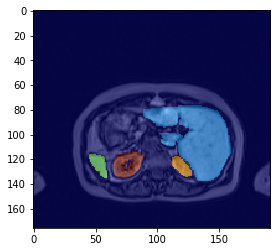

In [10]:
import matplotlib.pyplot as plt
img, label = nb.load(ukb_volumes[0]), nb.load(ukb_labels[0])
img_data = np.array(img.get_fdata())
label_data = np.array(label.get_fdata())

img_data = np.rollaxis(img_data, 2, 0)
label_data = np.rollaxis(label_data, 2, 0)

x = img_data.shape[0]//2
masked = label_data
plt.figure()
plt.imshow(np.rot90(img_data[x,:,:]), 'gray', interpolation='none')
plt.imshow(np.rot90(masked[x,:,:]), 'jet', interpolation='none', alpha=0.5)
plt.show()

In [4]:
im, seg = first(loader)
print(im.shape, seg.shape)

torch.Size([3, 1, 176, 112]) torch.Size([3, 176, 112])
